<a href="https://colab.research.google.com/github/MatthewKan2005/James-Stein-/blob/main/COTS_YOLOv5_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS5131 Project - Detecting Crown of Thorns Starfish (COTS) in Underwater Videos of the Great Barrier Reef**

**By Jed Lim and Matthew Kan (M22505)**

## **Contents**

[Introduction](#Introduction)

[Initial Setup](#InitialSetup)

[Exploratory Data Analysis](#EDA)

[Train the YOLOv5 Model](#YOLOV5Training)

[Predict using the YOLOv5 Model](#PredictYOLOv5)

[Evaluation Metrics](#EvalYOLOv5)


![Coral Reef](https://drive.google.com/uc?id=1iTrQg8xJKa-6uqZzJxZBEKCxWEp5Zy2u)

# <a name = "Introduction"></a>**Introduction**

The Great Barrier Reef in Australia is the world's largest coral reef and home to a diverse variety of marine life. However, the reef is threatened by the overpopulation of the coral-eating crown-of-thorns-starfish (COTS), which devours living coral at a devastating rate. 

Identifying COTS breakouts that are threatening the Great Barrier Reef will allow COTS population control measures to be undertaken to protect the reef. 


### Objective

To accurately identify COTS in real-time by developing an object detection model trained on underwater videos of the Great Barrier Reef. 

### Target Users

1) Austalia's National Science Agency - the Commonwealth Science and Industrial Research Organisation (CSIRO)

2) Other coral reef protection agencies

## <a name = "InitialSetup"></a>**Initial Setup**

### Import Libraries

In [1]:
import warnings 
warnings.filterwarnings("ignore") 

import os 
from os.path import isfile, join 
from os import listdir 
import sys 
import torch 
import shutil 
from shutil import copyfile 
import yaml 
from tqdm.notebook import tqdm 
tqdm.pandas() 
import cv2 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from joblib import Parallel, delayed 
from itertools import groupby 
import pickle 
from multiprocessing import Pool 
import ast 

### Connect to Google Drive

In [2]:
import glob
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


### Install the Kaggle API in Colab
### Authenticate with Kaggle using kaggle.json

In [3]:
!pip install kaggle

In [4]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Download the Great Barrier Reef Dataset

In [5]:
!kaggle datasets download -d yondraco/tensorflowgreatbarrierreef

100% 14.2G/14.2G [01:39<00:00, 210MB/s]
100% 14.2G/14.2G [01:39<00:00, 153MB/s]


In [6]:
# unzip the downloaded dataset
!mkdir /kaggle
!mkdir /kaggle/input
!mkdir /kaggle/input/tensorflow-great-barrier-reef
!unzip -q ./tensorflowgreatbarrierreef.zip -d /kaggle/input/tensorflow-great-barrier-reef

In [7]:
%mkdir /kaggle/working
%cd /kaggle/working

/kaggle/working


### Download YOLOv5

In [8]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

# Install dependencies
%pip install -qr requirements.txt  

# change directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 11813, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 11813 (delta 9), reused 15 (delta 5), pack-reused 11793
Receiving objects: 100% (11813/11813), 11.41 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (8165/8165), done.
/kaggle/working/yolov5
     |████████████████████████████████| 596 kB 5.5 MB/s 
/kaggle/working
Setup complete. Using torch 1.10.0+cu111 (Tesla K80)


In [9]:
TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'

## <a name = "EDA"></a>**Exploratory Data Analysis**

In [10]:
# Read in the data CSV files
df = pd.read_csv("/kaggle/input/tensorflow-great-barrier-reef/train.csv")
df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


### Number of images of the Great Barrier Reef in the videos recordings

In [11]:
to_bar = df["video_id"].value_counts().sort_index(ascending = True)
to_bar = pd.DataFrame(to_bar)
to_bar = to_bar.reset_index(drop = False)
to_bar = to_bar.rename(columns = {"video_id" : "Number of Images"})
to_bar = to_bar.rename(columns = {"index" : "video_id"})
to_bar

,video_id,Number of Images
0,0,6708
1,1,8232
2,2,8561


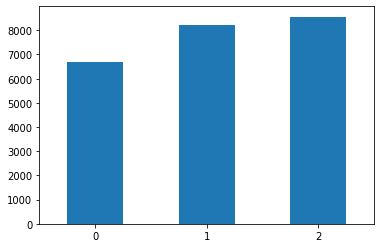

In [12]:
to_bar.plot(kind = "bar", y = "Number of Images", rot = 0, legend = False)
plt.show()

The dataset has 23 501 images of the Great Barrier Reef from 3 video recordings. 

### Number of images that contain COTS 

In [13]:
# Determine the number of COTS in each image
df["NumBBox"]=df['annotations'].apply(lambda x: str.count(x, 'x'))
df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,NumBBox
0,0,40258,0,0,0-0,[],0
1,0,40258,1,1,0-1,[],0
2,0,40258,2,2,0-2,[],0
3,0,40258,3,3,0-3,[],0
4,0,40258,4,4,0-4,[],0


In [14]:
df_cots=df[df["NumBBox"]>0]
df_cots.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,NumBBox
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1


In [15]:
print(df_cots['NumBBox'].sum())

11898


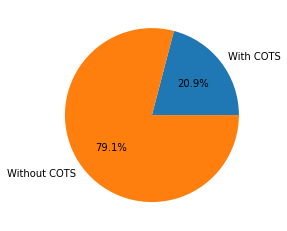

In [16]:
number_with_cots = df_cots.shape[0]
number_without_cots = df.shape[0] - number_with_cots

to_pie = pd.DataFrame([[number_with_cots],
                       [number_without_cots]],
                      index = ["With COTS", "Without COTS"],
                      columns = ["Count"])

to_pie.plot(kind = "pie", autopct = "%1.1f%%", labels = to_pie.index, y = "Count", ylabel = "", legend = False)

plt.show()

4919 (20.9%) of the images contain Crown of Thorns Starfish (COTS). There are 11898 COTs altogether. 

### Number of COTS in each image

In [17]:
bbox_to_plot = pd.DataFrame(df["NumBBox"].value_counts().sort_index(ascending = True))
bbox_to_plot = bbox_to_plot.reset_index(drop = False)
bbox_to_plot = bbox_to_plot.rename(columns = {"index" : "Number of COTS", "NumBBox" : "Number of Images"})
bbox_to_plot

,Number of COTS,Number of Images
0,0,18582
1,1,2801
2,2,942
3,3,374
4,4,240
5,5,134
6,6,59
7,7,61
8,8,58
9,9,32


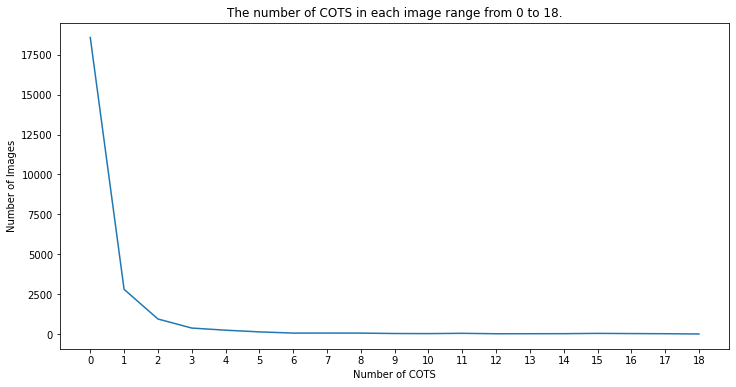

In [18]:
plt.figure(figsize = (12, 6))
ax = sns.lineplot(data = bbox_to_plot, x = "Number of COTS", y = "Number of Images")
plt.title("The number of COTS in each image range from 0 to 18.")
xticks = np.arange(0, 19)
ax.set_xticks(xticks)
plt.show()

## <a name = "YOLOV5Training"></a>**Train the YOLOv5 Model**

## Step 1: Data Preparation

### Determine the COCO bboxes for each image

In [19]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

In [20]:
df_cots['annotations'] = df_cots['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_cots['bboxes'] = df_cots.annotations.progress_apply(get_bbox)
df_cots.sample(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,NumBBox,bboxes
20166,2,22643,6264,901,2-6264,"[{'x': 500, 'y': 647, 'width': 36, 'height': 3...",2,"[[500, 647, 36, 36], [466, 689, 36, 30]]"
7397,1,60510,689,689,1-689,"[{'x': 201, 'y': 623, 'width': 95, 'height': 96}]",1,"[[201, 623, 95, 96]]"


### Determine the size of the images

In [21]:
df_cots["Width"]=1280
df_cots["Height"]=720
df_cots.sample(2)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,NumBBox,bboxes,Width,Height
10779,1,8503,5627,1799,1-5627,"[{'x': 578, 'y': 56, 'width': 24, 'height': 21}]",1,"[[578, 56, 24, 21]]",1280,720
5205,0,53708,9382,497,0-9382,"[{'x': 580, 'y': 335, 'width': 79, 'height': 62}]",1,"[[580, 335, 79, 62]]",1280,720


All images have Width=1280 & Height=720

### Determine the paths for the images

In [22]:
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [23]:
df_cots = df_cots.progress_apply(get_path, axis=1)
df_cots.sample(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,NumBBox,bboxes,Width,Height,image_path
347,0,40258,347,347,0-347,"[{'x': 296, 'y': 181, 'width': 36, 'height': 33}]",1,"[[296, 181, 36, 33]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...
5243,0,53708,9420,535,0-9420,"[{'x': 832, 'y': 348, 'width': 33, 'height': 40}]",1,"[[832, 348, 33, 40]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...


### Load the images

In [24]:
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

## Step 2: Bounding Boxes

### Convert COCO bboxes to YOLO bboxes

We need to create a function that converts the Common Objects in Context (COCO) bboxes to YOLO bboxes.

Hence, we need to go from [xmin, ymin, w, h] to the corresponding yolo format [xmid, ymid, w, h].

![COCOTOYOLO](https://drive.google.com/uc?id=10_xK0BiknxctdPLK6Ez8Pprfc2L_qJSV)

In [25]:
def coco2yolo(image_height, image_width, bboxes):
   bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
   # normolizinig
   bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
   bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
   # converstion (xmin, ymin) => (xmid, ymid)
   bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
   return bboxes

### Draw the Bounding Boxes

In [26]:
def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [0, 0, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    if bbox_format == 'yolo':
        for idx in range(len(bboxes)):  
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            if cls in show_classes:
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)
                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
    return image

np.random.seed(8)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
colors=(255,0,0)

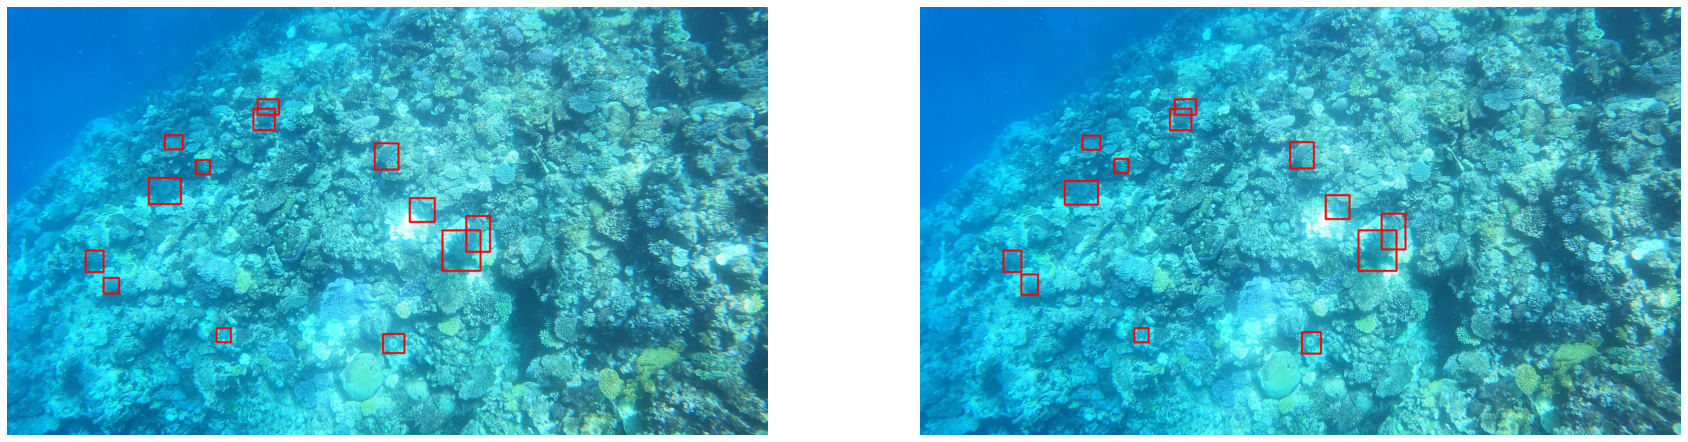

In [62]:
df_v = df_cots[(df_cots.NumBBox==13)].sample(2) 
fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    img           = load_image(row.image_path)
    image_height  = row.Height
    image_width   = row.Width
    bboxes_coco   = np.array(row.bboxes)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    names = [""] * len(bboxes_yolo)
    labels        = [0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

## Step 3: Configure YOLOV5

### Weights & Biases
* Weights & Biases is a set of tools that tracks machine learning experiments, visualizes metrics, and shares results.
* Weights & Biases is directly integrated into YOLOv5 and provides experiment metric tracking

In [28]:
!pip install -q --upgrade wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 144 kB 13.0 MB/s 
     |████████████████████████████████| 181 kB 35.2 MB/s 
     |████████████████████████████████| 63 kB 458 kB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Organize Directories

I organized train, val and test images and labels according to the example below.

```
/Kaggle/working
    /COTS
         /images
             /train/img0.jpg
             /val
             /test
         /labels
             /train/img0.txt
             /val
             /test
    /yolov5
```

In [29]:
pwd

'/kaggle/working'

In [30]:
os.makedirs('COTS/images/train', exist_ok=True)
os.makedirs('COTS/images/valid', exist_ok=True)
os.makedirs('COTS/images/test', exist_ok=True)
os.makedirs('COTS/labels/train', exist_ok=True)
os.makedirs('COTS/labels/valid', exist_ok=True)
os.makedirs('COTS/labels/test', exist_ok=True)

### Splitting Dataset

I split the dataset into 80% train, 10% validation and 10% test. 

### Populating the Images Folder

In [31]:
for i in tqdm(range(len(df_cots))):
    row = df_cots.iloc[i]
    if i <= df_cots.shape[0] * 4 // 5:
        copyfile(f'{row.image_path}', f'COTS/images/train/{row.image_id}.jpg')
    elif i <= df_cots.shape[0] * 9 // 10:
        copyfile(f'{row.image_path}', f'COTS/images/valid/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'COTS/images/test/{row.image_id}.jpg')

  0%|          | 0/4919 [00:00<?, ?it/s]

In [32]:
list1 = os.listdir('/kaggle/working/COTS/images/train') 
number_files1 = len(list1)
print("Number of images in ./COTS/images/train folder",number_files1)

list2 = os.listdir('/kaggle/working/COTS/images/valid') 
number_files2 = len(list2)
print("Number of images in ./COTS/images/valid folder",number_files2)

list3 = os.listdir("/kaggle/working/COTS/images/test")
number_files3 = len(list3)
print("Number of images in ./COTS/images/test folder",number_files3)

Number of images in ./COTS/images/train folder 3936
Number of images in ./COTS/images/valid folder 492
Number of images in ./COTS/images/test folder 491


### Populating the Labels Folder

In [33]:
all_bboxes = []
for row_idx in tqdm(range(df_cots.shape[0])):
    row = df_cots.iloc[row_idx]
    # Get image
    image_name = row.image_id
    image_height = row.Height
    image_width  = row.Width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    
    labels       = [0]*num_bbox

    if row_idx <= df_cots.shape[0] * 4 // 5:
        file_name = f'/kaggle/working/COTS/labels/train/{image_name}.txt'
    elif row_idx <= df_cots.shape[0] * 9 // 10:
        file_name = f'/kaggle/working/COTS/labels/valid/{image_name}.txt'
    else:
        file_name = f'/kaggle/working/COTS/labels/test/{image_name}.txt'



    with open(file_name, 'w') as f:
        bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            bb=str(bboxes_yolo[bbox_idx])
            bb=bb[1:-1]
            annot = str(str(labels[bbox_idx])) + ' ' + bb + '\n'
            annot = ''.join(annot)
            annot = annot.strip('')
            f.write(annot)

  0%|          | 0/4919 [00:00<?, ?it/s]

In [34]:
list1 = os.listdir('/kaggle/working/COTS/labels/train') # dir is your directory path
number_files1 = len(list1)
print("Number of txt file in ./COTS/labels/train folder",number_files1)

list2 = os.listdir('/kaggle/working/COTS/labels/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of txt file in ./COTS/labels/valid folder",number_files2)

list3 = os.listdir('/kaggle/working/COTS/labels/test') # dir is your directory path
number_files2 = len(list2)
print("Number of txt file in ./COTS/labels/test folder",number_files2)

Number of txt file in ./COTS/labels/train folder 3936
Number of txt file in ./COTS/labels/valid folder 492
Number of txt file in ./COTS/labels/test folder 492


### Create `Data.YAML` file

The `data.yaml`, is the dataset configuration file that defines:

1. the dataset root directory and relative paths to train/val/test image directories (or paths to *.txt files with image paths).
1. the number of classes.
1. a list of class names.

Note: The `data.yaml` is created in the `yolov5/data` directory as required. 

In [35]:
from glob import glob
import yaml
with open('/kaggle/working/train.txt', 'w') as f:
    for path in glob('/kaggle/working/train/*'):
        f.write(path+'\n')
            
with open('/kaggle/working/val.txt', 'w') as f:
    for path in glob('/kaggle/working/val/*'):
        f.write(path+'\n')

data = dict(
    train = '/kaggle/working/COTS/images/train',
    val = '/kaggle/working/COTS/images/valid',
    
    nc    = 1, # number of classes
    names =  ['cots'] # classes
    )

with open('/kaggle/working/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

%cat /kaggle/working/yolov5/data/data.yaml

names:
- cots
nc: 1
train: /kaggle/working/COTS/images/train
val: /kaggle/working/COTS/images/valid


In [36]:
!ls '/kaggle/working/yolov5/data'

Argoverse.yaml	GlobalWheat2020.yaml  scripts	     xView.yaml
coco128.yaml	hyps		      SKU-110K.yaml
coco.yaml	images		      VisDrone.yaml
data.yaml	Objects365.yaml       VOC.yaml


## Step 4: Train the YOLOv5 Model

#### Transfer Learning

Transfer learning is expected to produce better results than learning from scratch. The model was pre-trained over the COCO dataset. COCO is an object detection dataset with 80 classes. Oor model was initialized with weights from the COCO model. 

![YOLOv5 Architecture](https://drive.google.com/uc?id=1jJ60uRCh1TB1P2XDu5TofS-K_V3bPUVL)

### Parameters

In [37]:
# Parameters
BATCH_SIZE = 16
EPOCHS = 30
IMG_SIZE=1280

### Train with W&B

In [38]:
%cd yolov5/

/kaggle/working/yolov5


All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/exp2, runs/train/exp3 etc. 

In [39]:
# Train 2 epochs for now
EPOCHS = 2

In [50]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project kaggle-Reef \
                 --name feature-extraction

wandb: Currently logged in as: greatbarrierreef (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=kaggle-Reef, name=feature-extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Total 7 (delta 6), reused 7 (delta 6), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/ultralytics/yolov5
   fdc363d..eeb4191  test/conv_reduction -> origin/test/conv_reduction
github: up to date with https://g

## Step 5: Validate the YOLOv5 Model

In [56]:
!python val.py --img {IMG_SIZE} \
               --batch {BATCH_SIZE} \
               --data data.yaml \
               --weights kaggle-Reef/feature-extraction2/weights/best.pt \
               --project kaggle-Reef \
               --name validation \
               --augment            

val: data=/kaggle/working/yolov5/data/data.yaml, weights=['kaggle-Reef/feature-extraction2/weights/best.pt'], batch_size=16, imgsz=1280, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=kaggle-Reef, name=validation, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-62-ga0a4adf torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/kaggle/working/COTS/labels/valid.cache' images and labels... 492 found, 0 missing, 0 empty, 0 corrupt: 100% 492/492 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 31/31 [00:59<00:00,  1.92s/it]
                 all        492       1437      0.459      0.525      0.435      0.139
Speed: 0.7ms pre-process, 94.6ms inference, 17.1ms NMS per image at shape (16, 3, 1

## <a name = "PredictYOLOv5"></a>**Predict using the YOLOv5 Model**

In [60]:
!python detect.py --source '/kaggle/working/COTS/images/test' \
                  --weights kaggle-Reef/feature-extraction2/weights/best.pt \
                  --conf 0.6 \
                  --iou 0.45 \
                  --augment \
                  --project Kaggle-reef \
                  --name detection

detect: weights=['kaggle-Reef/feature-extraction2/weights/best.pt'], source=/kaggle/working/COTS/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=Kaggle-reef, name=detection, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-62-ga0a4adf torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/491 /kaggle/working/COTS/images/test/2-10619.jpg: 384x640 Done. (0.132s)
image 2/491 /kaggle/working/COTS/images/test/2-10620.jpg: 384x640 Done. (0.121s)
image 3/491 /kaggle/working/COTS/images/test/2-10621.jpg: 384x640 Done. (0.118s)
image 4/491 /kaggle/working/COTS/images/test/2-10622.jpg: 384x640 Done. (0.115s)
image 5/491 /kag

## <a name = "EvalYOLOv5"></a>**Evaluation Metrics**

Precision measures the percentage of the COTS predictions that are correct. 

Recall measures the percentage of the COTS that were correctly predicted. 

mAP_0.5 is the mean average precision at IoU (intersection over Uniob) threshold of 0.5. 

mAP_0.5:0.95 is the average mAP over different IoU thresholds, ranging from 0.5 to 0.95.  